In [1]:
import numpy as np
import torch
import pyepo

# set random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-01
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.80it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 141.61it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 137.11it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.25it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-0.5, num_epochs+0.5)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
num_epochs = 20
log_step = 1

In [11]:
import copy
import time
from tqdm import tqdm
import torch.nn.functional as F

from earlystop import earlyStopper
from clipgrad import clipGrad

def pipeline(reg, forward_func, loss_func, lr, num_epochs, 
             log_step, loader_train, loader_val, loader_test, grad_clip=False, seed=42):
    # set random seed
    np.random.seed(seed)
    torch.manual_seed(seed)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init best model
    best_model_state = copy.deepcopy(reg.state_dict())
    best_val_regret = float("inf")
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
            # update best model
            if regret_val < best_val_regret:
                best_val_regret = regret_val
                best_model_state = copy.deepcopy(reg.state_dict())
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # clip
            if grad_clip:
                clipGrad(reg, threshold=1e-6)
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".format(epoch, regret_trn*100, regret_val*100))
        # update best model
        if regret_val < best_val_regret:
            best_val_regret = regret_val
            best_model_state = copy.deepcopy(reg.state_dict())
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    # restore best model
    reg.load_state_dict(best_model_state)
    print()
    print("Evaluation:")
    tick = time.time()
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    tock = time.time()
    elapsed = tock - tick
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Test Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log, reg_lambda=1e-2):
    # unzip data
    x, c, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr) + reg_lambda * F.mse_loss(cp, c)
    return loss

### Exact Method with Clarabel

In [12]:
# init model
reg = LinearRegression()

In [13]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

(CVXPY) Dec 06 07:13:17 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: The specified module could not be found.')
Num of cores: 8


In [14]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 216.6579%, Val Regret: 224.0108%


Epoch    0, Loss:  -0.7465:   5%|██▊                                                    | 1/20 [00:29<06:14, 19.73s/it]

Epoch   1, Train Regret:  13.3203%, Val Regret:  14.5007%


Epoch    1, Loss:  -0.8908:  10%|█████▌                                                 | 2/20 [00:43<04:51, 16.22s/it]

Epoch   2, Train Regret:  14.4619%, Val Regret:  14.4818%


Epoch    2, Loss:  -0.8418:  15%|████████▎                                              | 3/20 [00:57<04:19, 15.27s/it]

Epoch   3, Train Regret:  13.3648%, Val Regret:  13.7928%


Epoch    3, Loss:  -0.8219:  20%|███████████                                            | 4/20 [01:10<03:53, 14.61s/it]

Epoch   4, Train Regret:  12.5238%, Val Regret:  12.3615%


Epoch    4, Loss:  -0.9280:  25%|█████████████▊                                         | 5/20 [01:25<03:32, 14.16s/it]

Epoch   5, Train Regret:  12.0830%, Val Regret:  12.7485%


Epoch    5, Loss:  -0.8861:  30%|████████████████▌                                      | 6/20 [01:39<03:20, 14.34s/it]

Epoch   6, Train Regret:  12.0955%, Val Regret:  11.7019%


Epoch    6, Loss:  -0.9028:  35%|███████████████████▎                                   | 7/20 [01:52<03:04, 14.23s/it]

Epoch   7, Train Regret:  11.8385%, Val Regret:  12.4026%


Epoch    7, Loss:  -0.9389:  40%|██████████████████████                                 | 8/20 [02:06<02:46, 13.90s/it]

Epoch   8, Train Regret:  12.0660%, Val Regret:  12.1621%


Epoch    8, Loss:  -0.9070:  45%|████████████████████████▊                              | 9/20 [02:19<02:50, 15.49s/it]


Epoch   9, Train Regret:  11.9888%, Val Regret:  12.0884%

Early Stop!
Training Elapsed Time: 31.86 Sec

Evaluation:
Test Regret: 12.4149%
Test Elapsed Time: 8.68 Sec


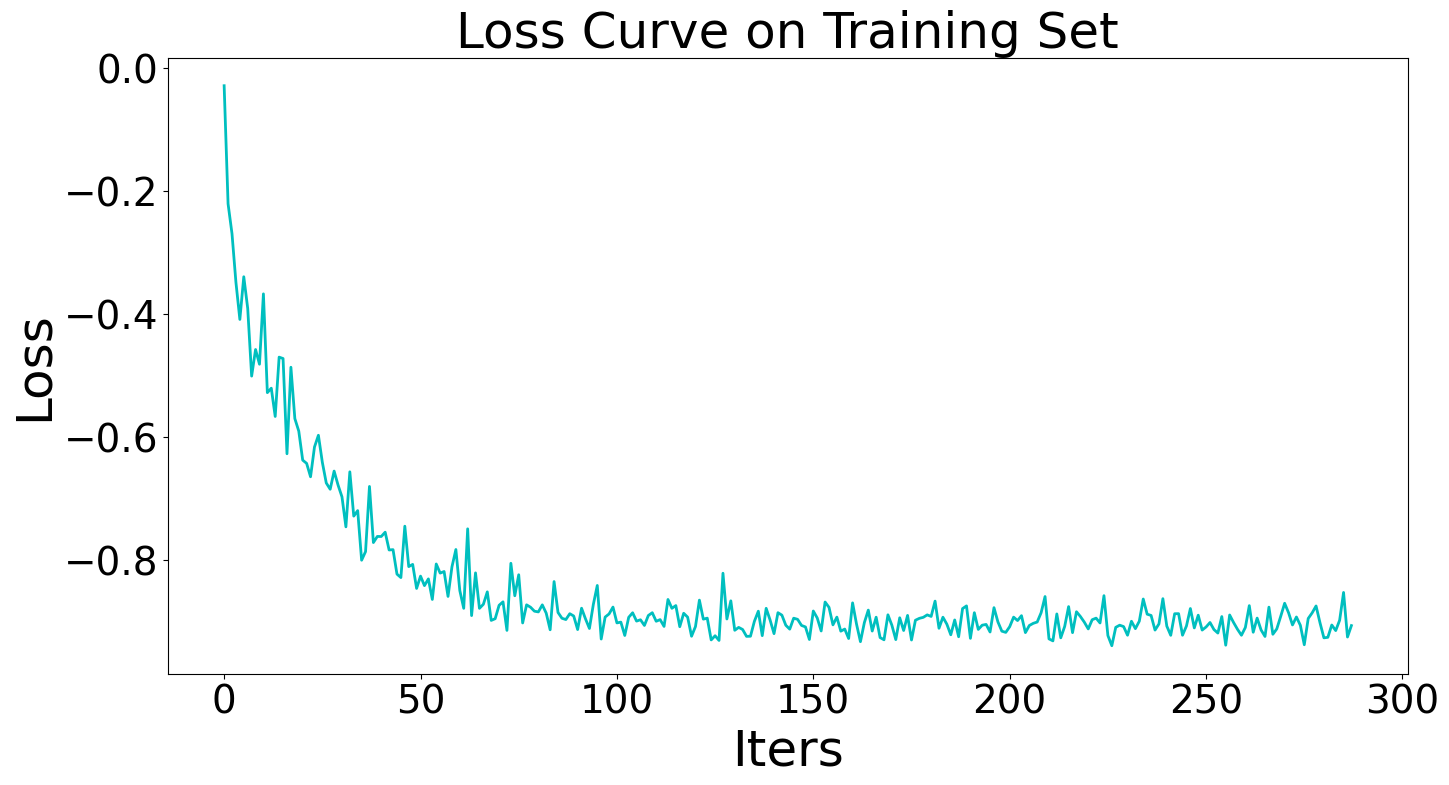

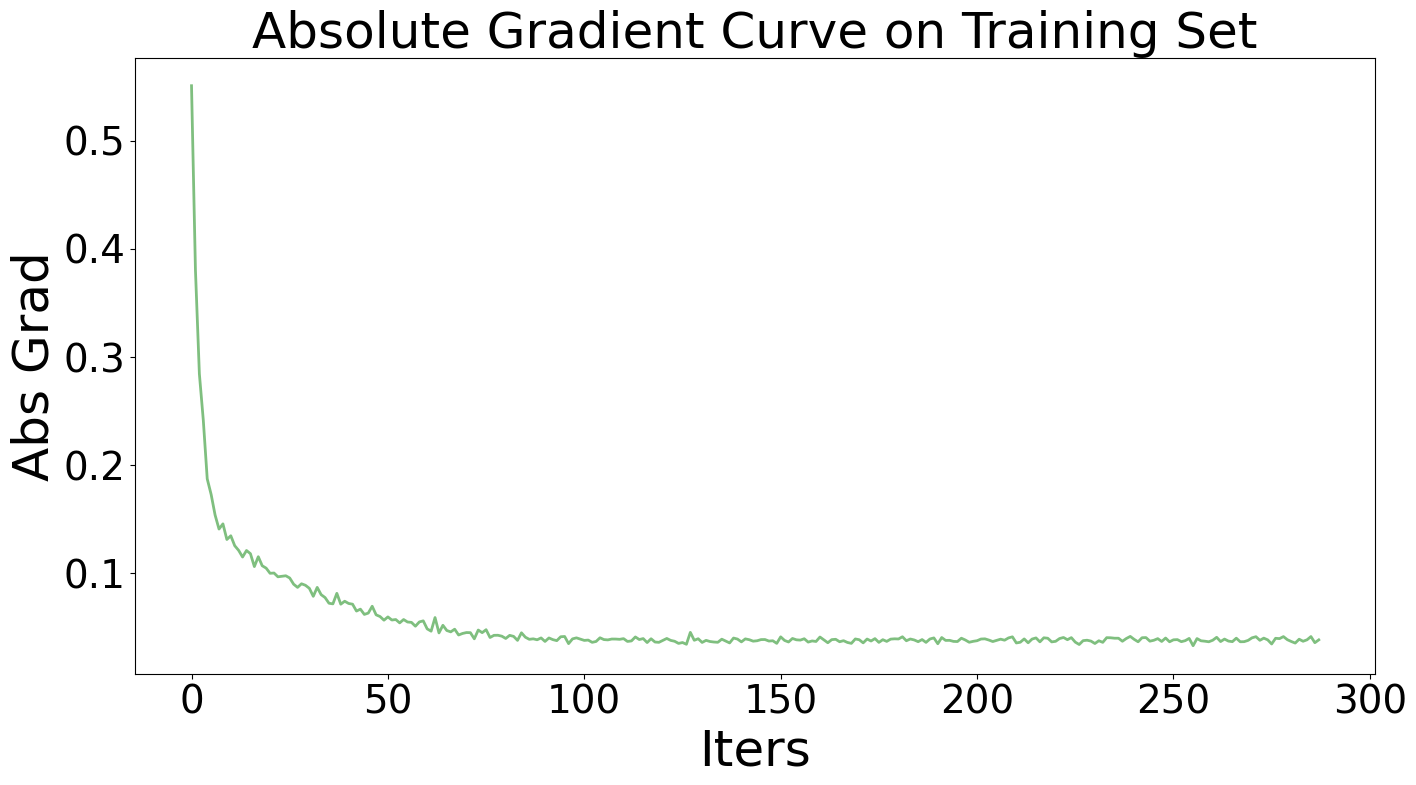

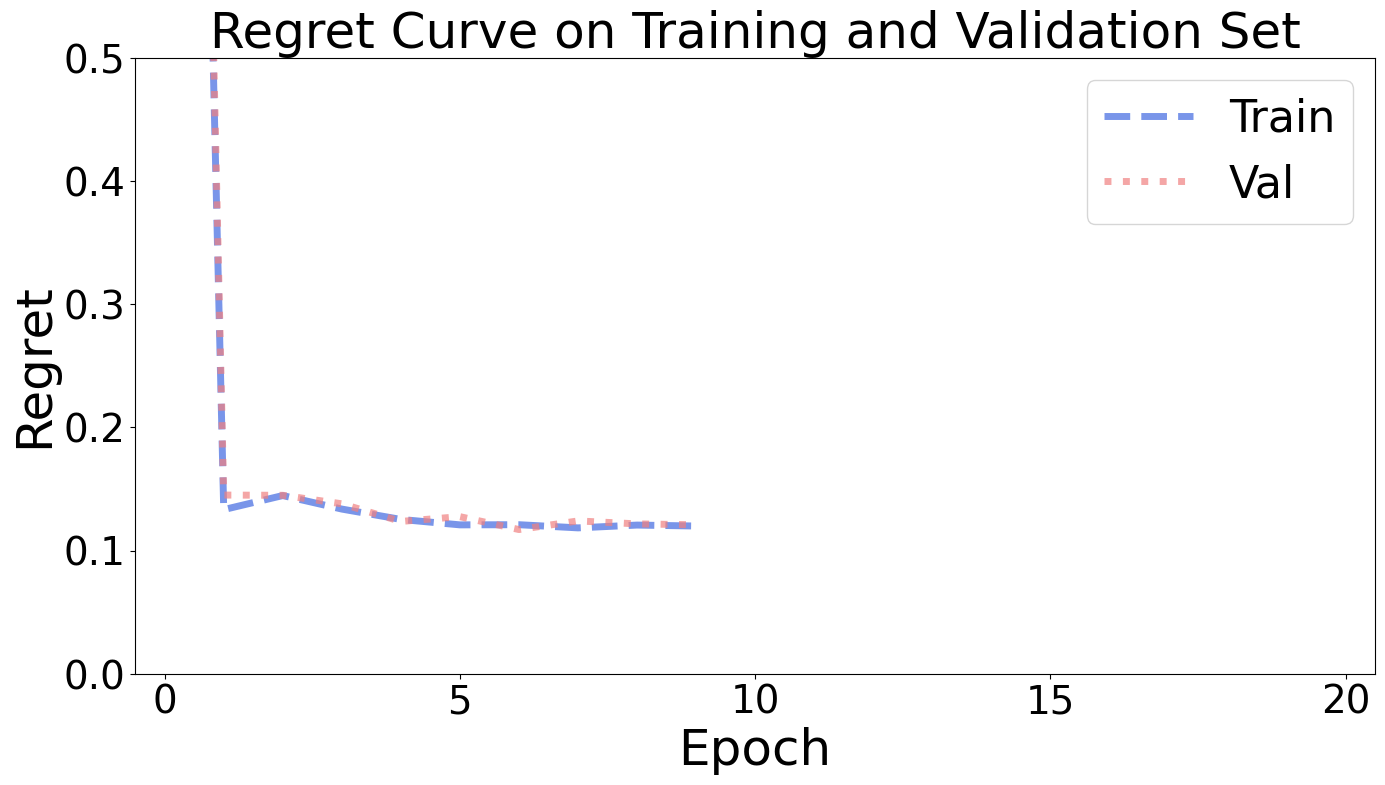

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Inner Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    0, Loss:  -0.7411:   5%|██▊                                                    | 1/20 [00:22<04:08, 13.06s/it]

Epoch   1, Train Regret:  11.6448%, Val Regret:  12.1181%


Epoch    1, Loss:  -0.8840:  10%|█████▌                                                 | 2/20 [00:35<03:54, 13.02s/it]

Epoch   2, Train Regret:  12.9319%, Val Regret:  13.1062%


Epoch    2, Loss:  -0.8368:  15%|████████▎                                              | 3/20 [00:49<03:43, 13.17s/it]

Epoch   3, Train Regret:  12.2127%, Val Regret:  12.8528%


Epoch    3, Loss:  -0.8193:  20%|███████████                                            | 4/20 [01:03<03:33, 13.35s/it]

Epoch   4, Train Regret:  11.5908%, Val Regret:  11.7830%


Epoch    4, Loss:  -0.9270:  25%|█████████████▊                                         | 5/20 [01:16<03:22, 13.51s/it]

Epoch   5, Train Regret:  11.2554%, Val Regret:  11.8524%


Epoch    5, Loss:  -0.8859:  30%|████████████████▌                                      | 6/20 [01:29<03:06, 13.33s/it]

Epoch   6, Train Regret:  11.2512%, Val Regret:  11.0934%


Epoch    6, Loss:  -0.9025:  35%|███████████████████▎                                   | 7/20 [01:42<02:53, 13.32s/it]

Epoch   7, Train Regret:  11.1920%, Val Regret:  11.4361%


Epoch    7, Loss:  -0.9384:  40%|██████████████████████                                 | 8/20 [01:55<02:39, 13.31s/it]

Epoch   8, Train Regret:  11.3931%, Val Regret:  11.4826%


Epoch    8, Loss:  -0.9062:  45%|████████████████████████▊                              | 9/20 [02:08<02:37, 14.33s/it]


Epoch   9, Train Regret:  11.3193%, Val Regret:  11.3690%

Early Stop!
Training Elapsed Time: 24.51 Sec

Evaluation:
Test Regret: 11.5616%
Test Elapsed Time: 8.65 Sec


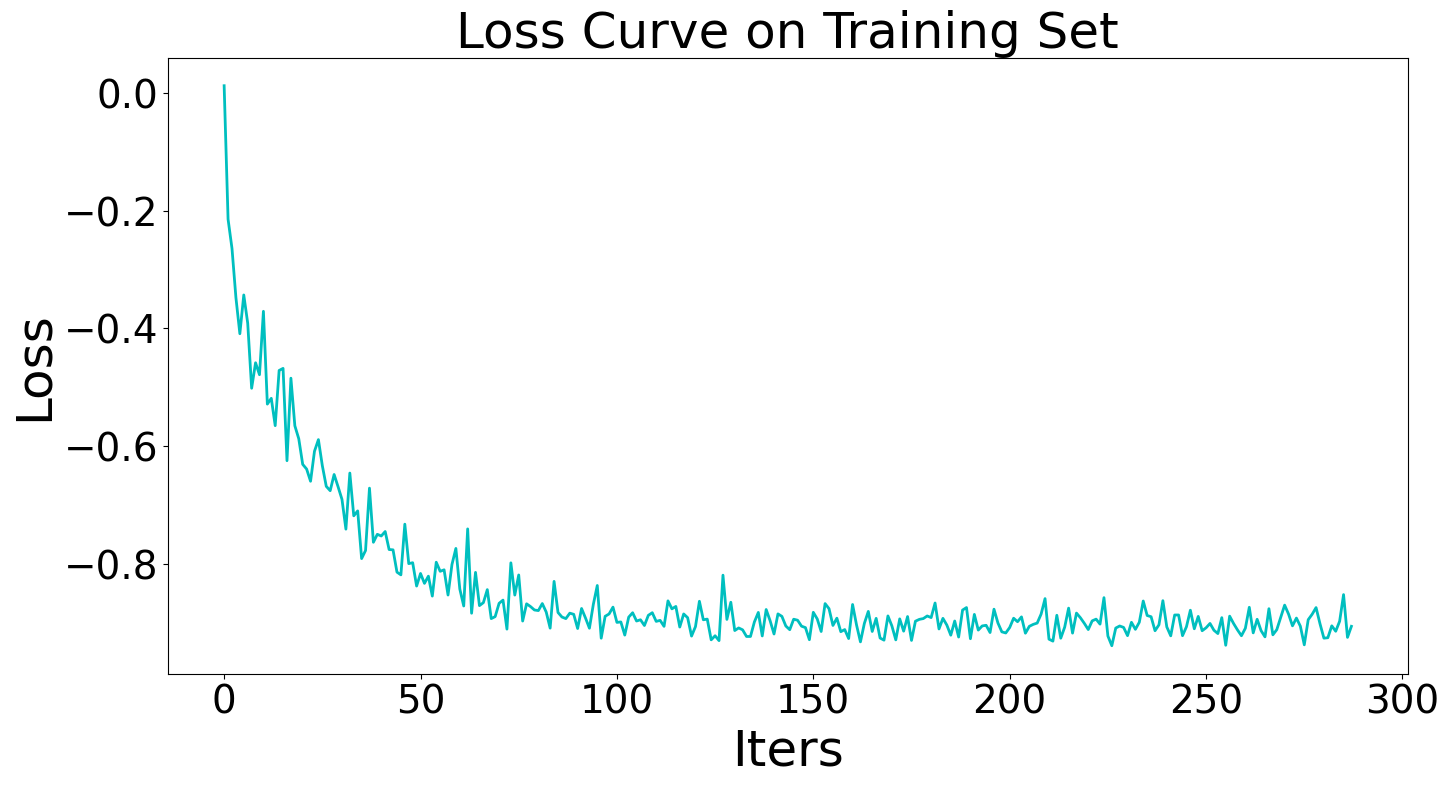

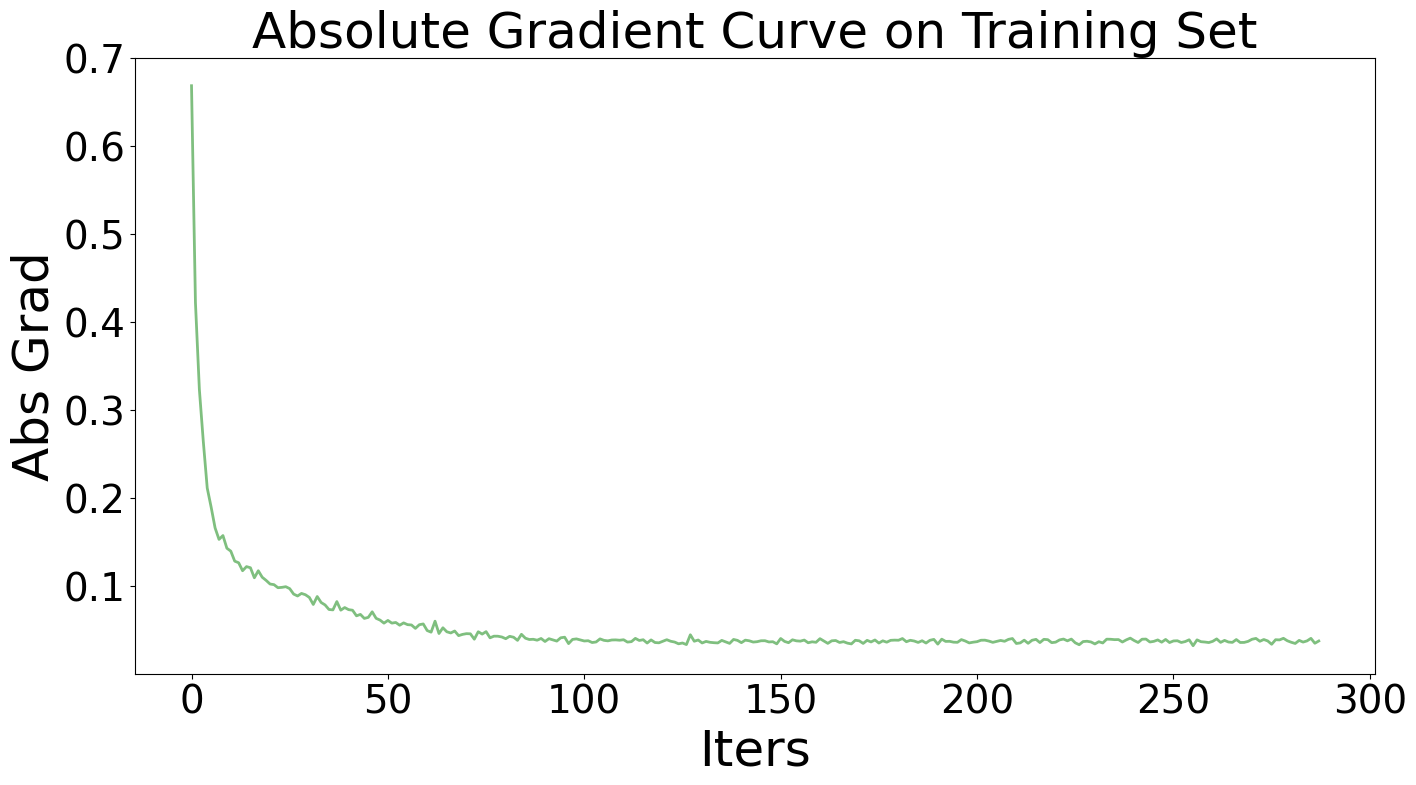

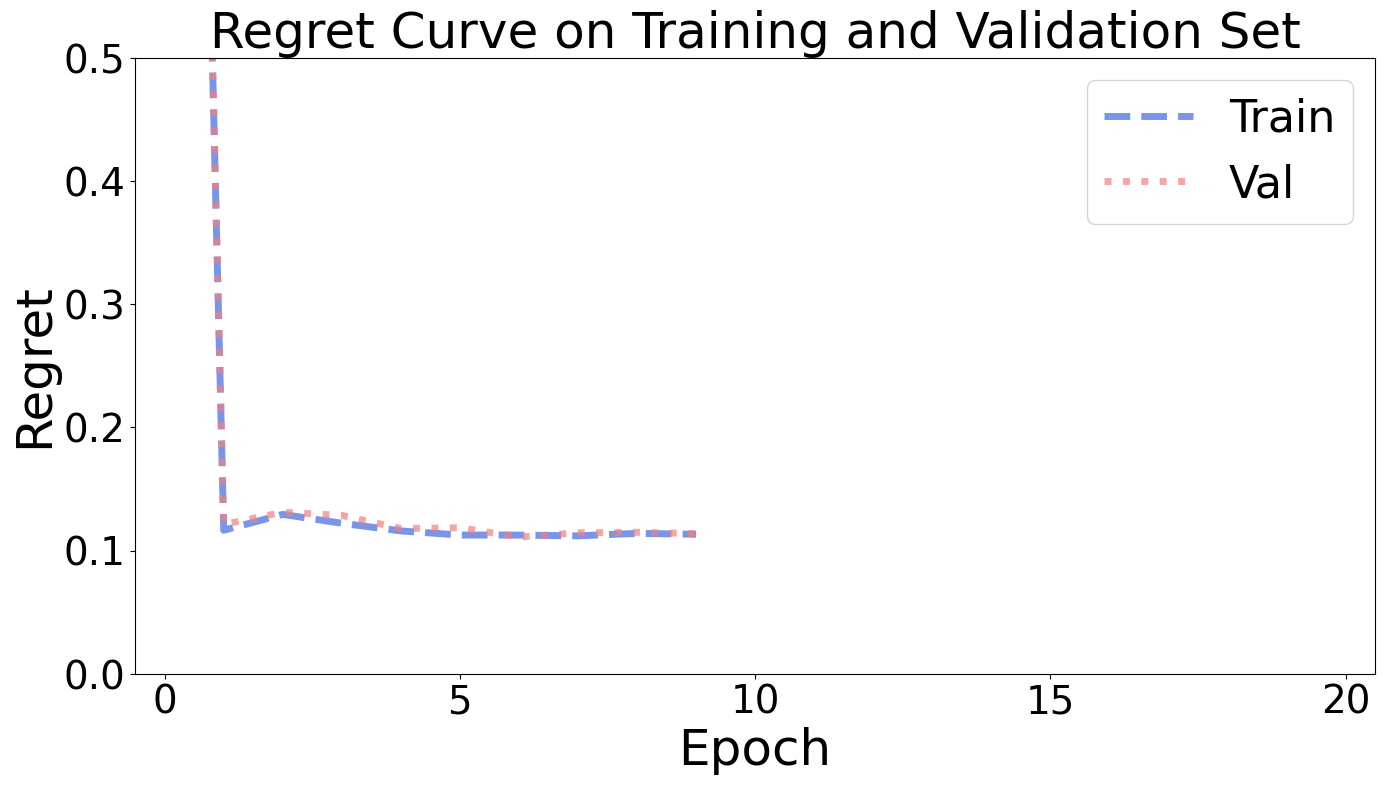

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Inner & Average Method

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import innerConeAlignedCosine
# init loss
ca_cos = innerConeAlignedCosine(optmodel, solver="clarabel", solve_ratio=0.3, processes=8)

Num of cores: 8


In [22]:
lr = 5e-2
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 210.3350%, Val Regret: 211.7011%


Epoch    0, Loss:  -0.6354:   5%|██▊                                                    | 1/20 [00:21<03:51, 12.16s/it]

Epoch   1, Train Regret:  15.0335%, Val Regret:  15.2068%


Epoch    1, Loss:  -0.7856:  10%|█████▌                                                 | 2/20 [00:34<03:34, 11.90s/it]

Epoch   2, Train Regret:  17.6145%, Val Regret:  17.5801%


Epoch    2, Loss:  -0.7479:  15%|████████▎                                              | 3/20 [00:46<03:25, 12.07s/it]

Epoch   3, Train Regret:  17.7969%, Val Regret:  17.0645%


Epoch    3, Loss:  -0.7744:  20%|███████████                                            | 4/20 [00:58<03:54, 14.64s/it]


Epoch   4, Train Regret:  17.0867%, Val Regret:  16.6912%

Early Stop!
Training Elapsed Time: 4.71 Sec

Evaluation:
Test Regret: 15.3631%
Test Elapsed Time: 8.85 Sec


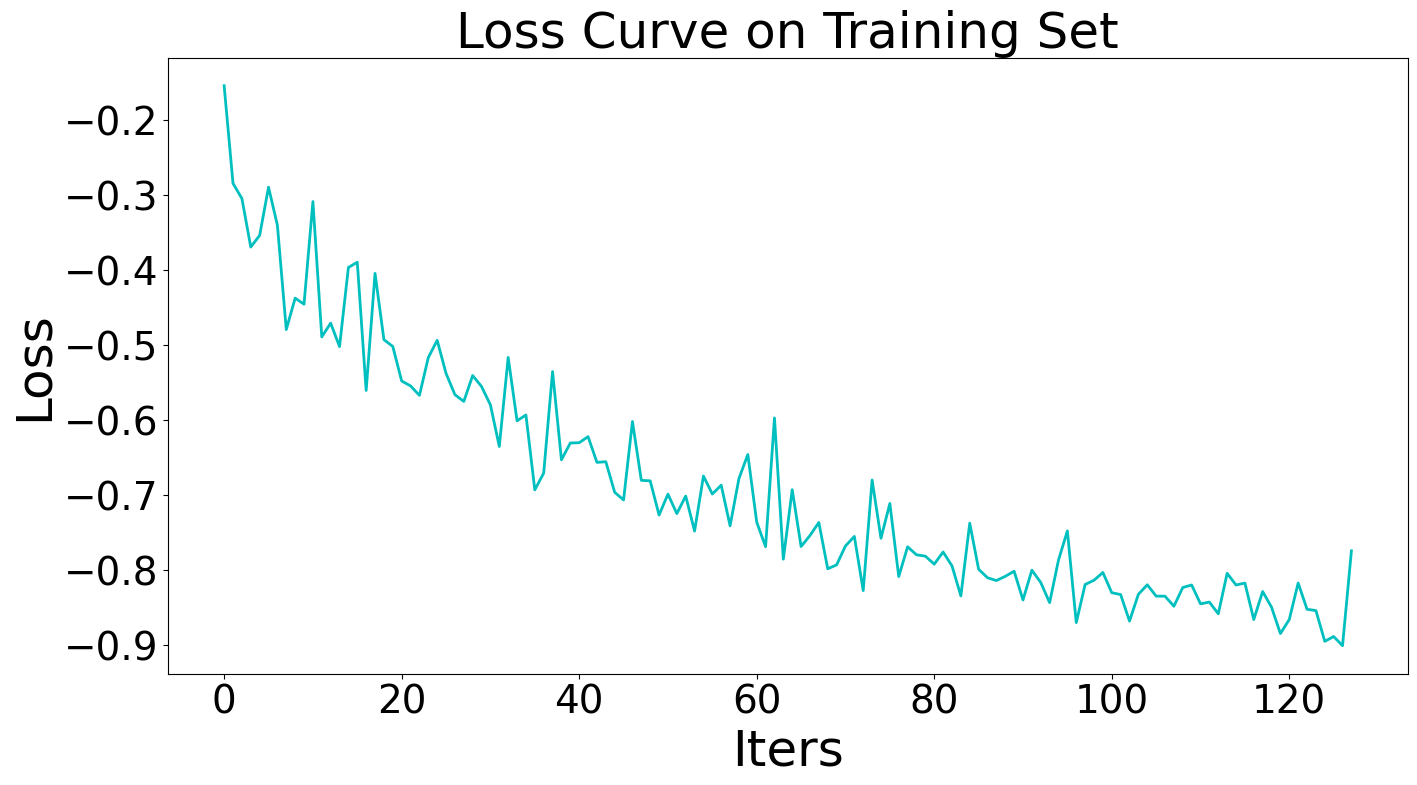

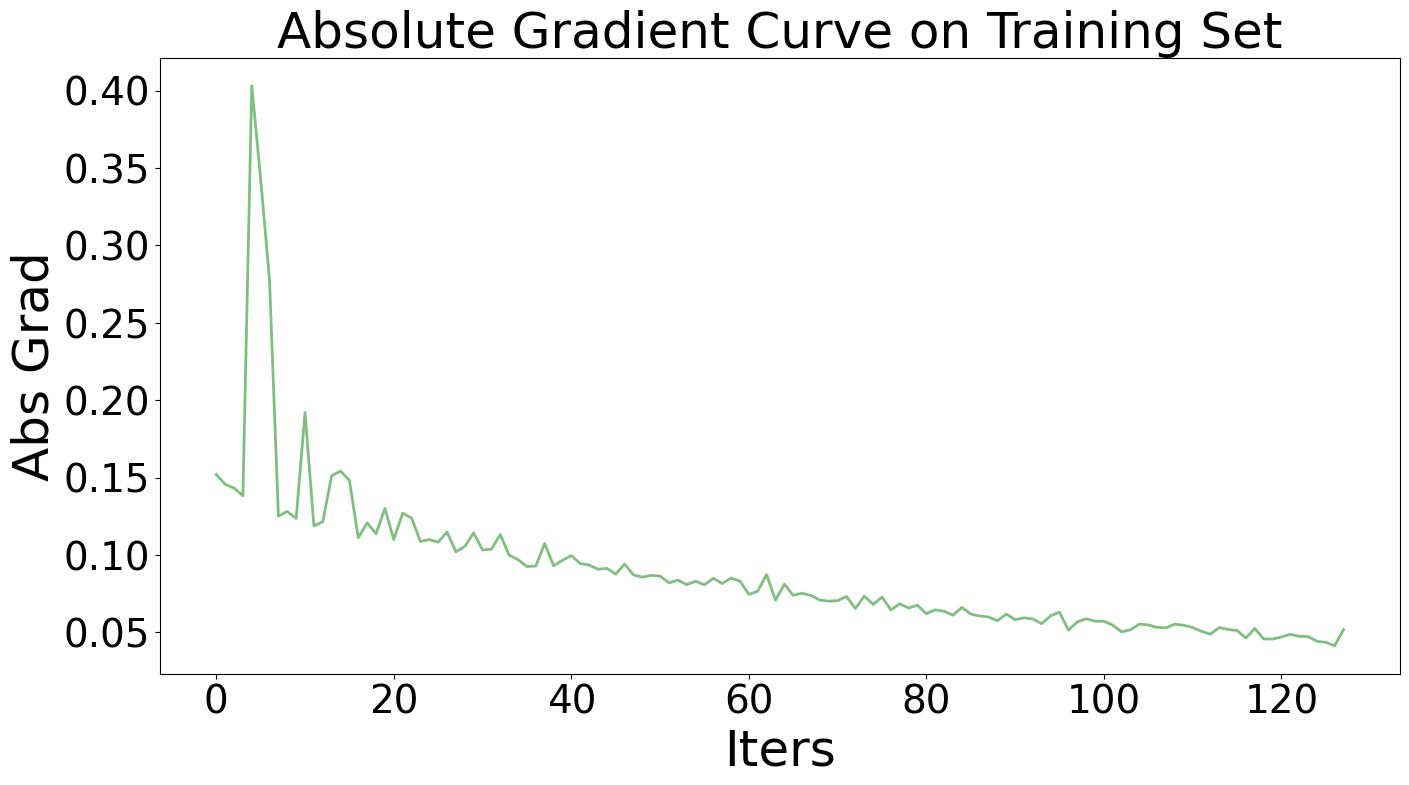

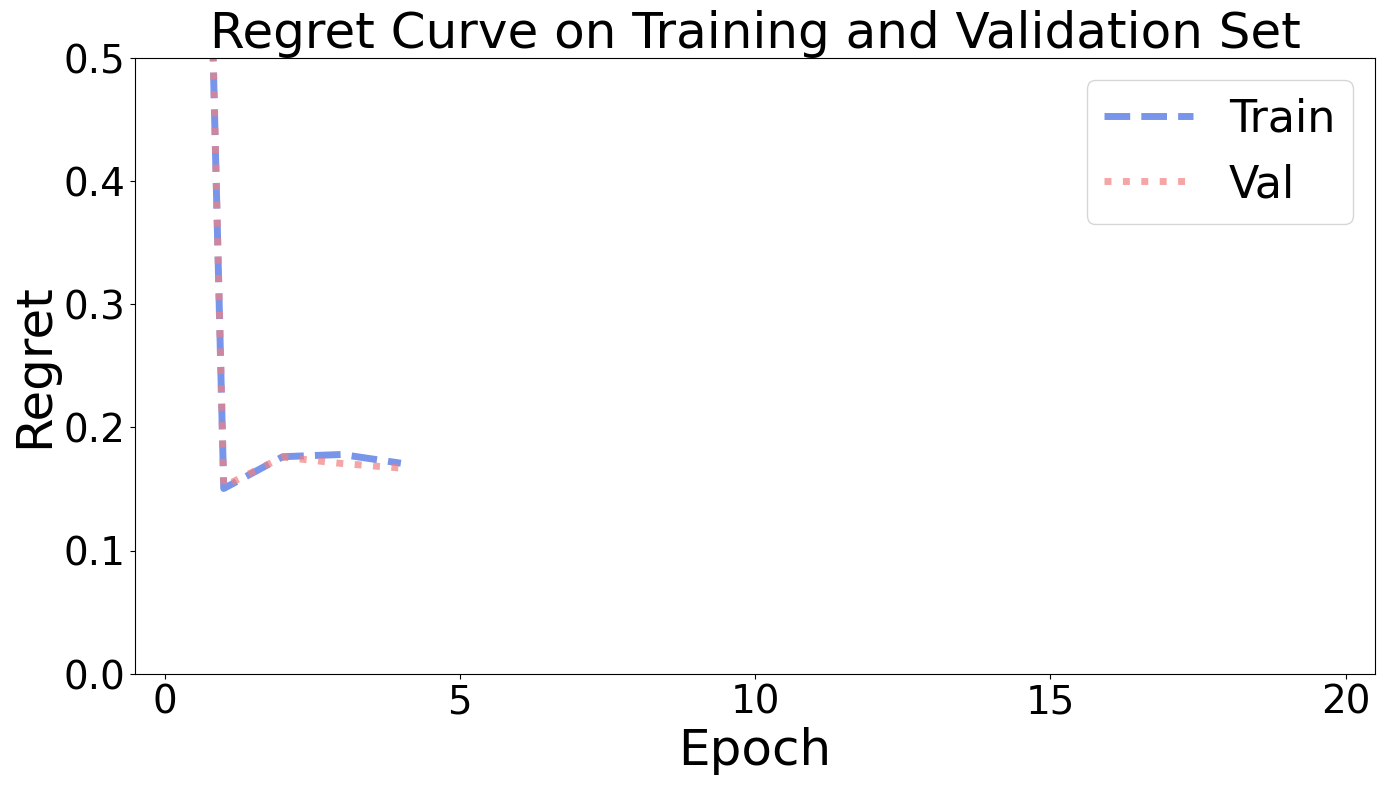

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4)

Num of cores: 1


In [26]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 181.1700%, Val Regret: 179.5455%


Epoch    0, Loss:  -0.7908:   5%|██▊                                                    | 1/20 [00:20<03:31, 11.13s/it]

Epoch   1, Train Regret:  19.5752%, Val Regret:  20.4863%


Epoch    1, Loss:  -0.9026:  10%|█████▌                                                 | 2/20 [00:31<03:18, 11.05s/it]

Epoch   2, Train Regret:  19.0224%, Val Regret:  19.6679%


Epoch    2, Loss:  -0.9180:  15%|████████▎                                              | 3/20 [00:42<03:09, 11.14s/it]

Epoch   3, Train Regret:  15.6330%, Val Regret:  15.4995%


Epoch    3, Loss:  -0.9020:  20%|███████████                                            | 4/20 [00:53<02:58, 11.13s/it]

Epoch   4, Train Regret:  13.3743%, Val Regret:  13.8326%


Epoch    4, Loss:  -0.9175:  25%|█████████████▊                                         | 5/20 [01:05<02:47, 11.14s/it]

Epoch   5, Train Regret:  12.7209%, Val Regret:  12.7463%


Epoch    5, Loss:  -0.8331:  30%|████████████████▌                                      | 6/20 [01:16<02:35, 11.14s/it]

Epoch   6, Train Regret:  12.2863%, Val Regret:  12.6337%


Epoch    6, Loss:  -0.9335:  35%|███████████████████▎                                   | 7/20 [01:27<02:25, 11.22s/it]

Epoch   7, Train Regret:  12.2933%, Val Regret:  13.2318%


Epoch    7, Loss:  -0.9302:  40%|██████████████████████                                 | 8/20 [01:39<02:14, 11.21s/it]

Epoch   8, Train Regret:  12.4190%, Val Regret:  12.3996%


Epoch    8, Loss:  -0.8706:  45%|████████████████████████▊                              | 9/20 [01:51<02:06, 11.46s/it]

Epoch   9, Train Regret:  12.1895%, Val Regret:  12.6033%


Epoch    9, Loss:  -0.8694:  50%|███████████████████████████                           | 10/20 [02:02<01:55, 11.56s/it]

Epoch  10, Train Regret:  12.2155%, Val Regret:  12.4989%


Epoch   10, Loss:  -0.8790:  55%|█████████████████████████████▋                        | 11/20 [02:13<01:48, 12.10s/it]


Epoch  11, Train Regret:  12.3986%, Val Regret:  12.4628%

Early Stop!
Training Elapsed Time: 8.08 Sec

Evaluation:
Test Regret: 12.6414%
Test Elapsed Time: 8.63 Sec


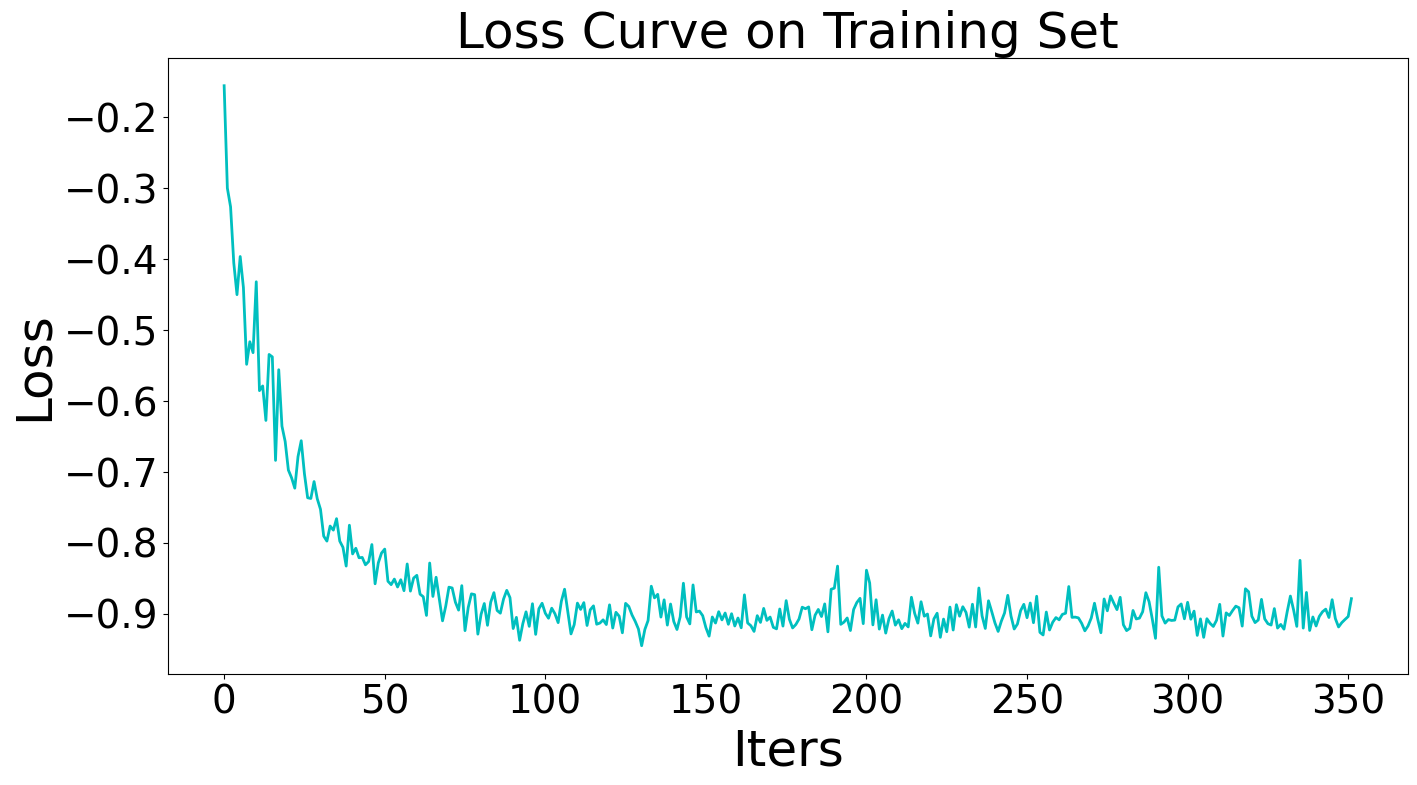

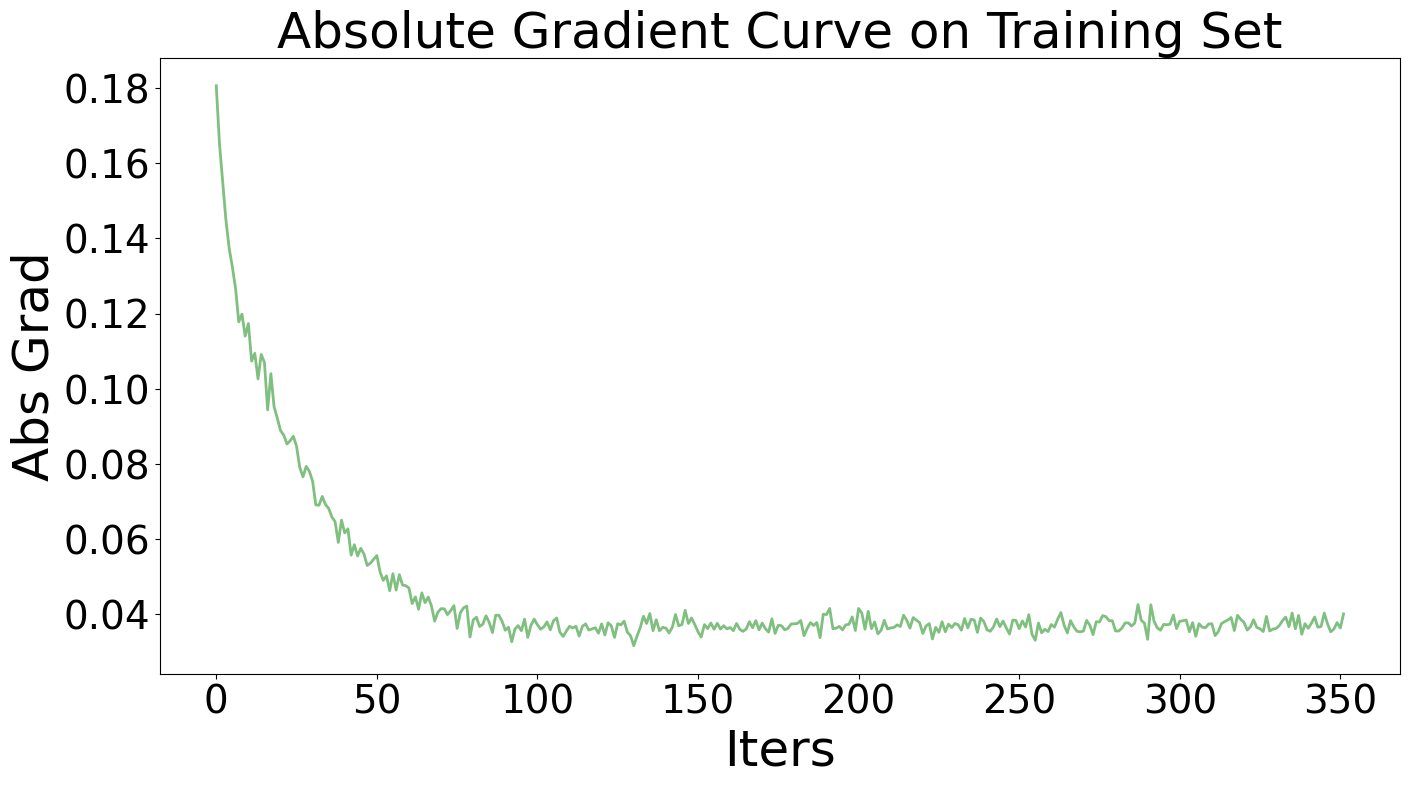

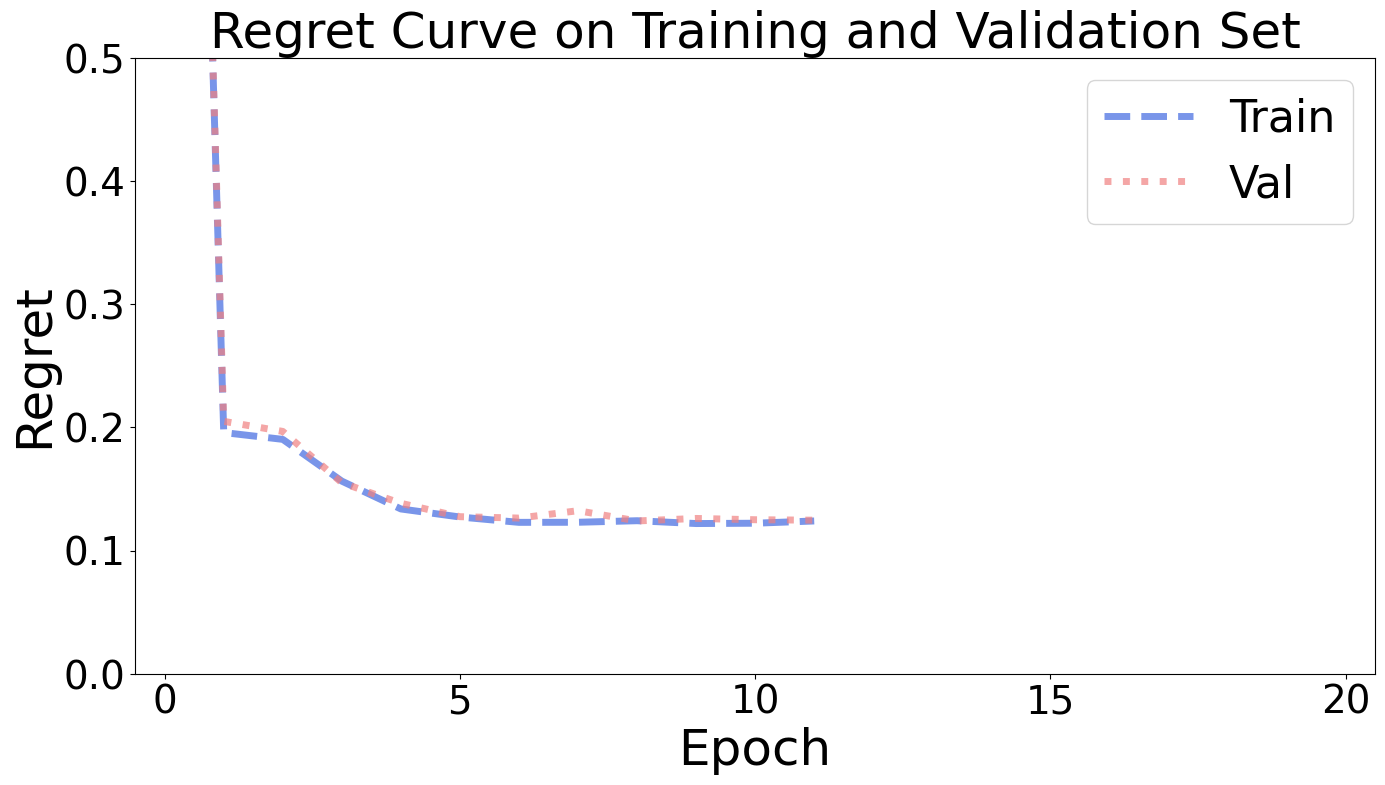

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method with Cone Check

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100, inner_ratio=0.4, check_cone=True, processes=8)

Num of cores: 8


In [30]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.1426%, Val Regret: 218.8037%


Epoch    0, Loss:  -0.7906:   5%|██▊                                                    | 1/20 [00:30<06:31, 20.62s/it]

Epoch   1, Train Regret:  20.2604%, Val Regret:  20.2133%


Epoch    1, Loss:  -0.9021:  10%|█████▌                                                 | 2/20 [00:51<06:18, 21.05s/it]

Epoch   2, Train Regret:  19.0234%, Val Regret:  19.1691%


Epoch    2, Loss:  -0.9179:  15%|████████▎                                              | 3/20 [01:12<05:58, 21.10s/it]

Epoch   3, Train Regret:  15.5783%, Val Regret:  15.5841%


Epoch    3, Loss:  -0.9018:  20%|███████████                                            | 4/20 [01:34<05:34, 20.89s/it]

Epoch   4, Train Regret:  13.4137%, Val Regret:  13.7960%


Epoch    4, Loss:  -0.9176:  25%|█████████████▊                                         | 5/20 [01:54<05:15, 21.05s/it]

Epoch   5, Train Regret:  12.6773%, Val Regret:  12.8053%


Epoch    5, Loss:  -0.8331:  30%|████████████████▌                                      | 6/20 [02:15<04:50, 20.77s/it]

Epoch   6, Train Regret:  12.2838%, Val Regret:  12.6337%


Epoch    6, Loss:  -0.9335:  35%|███████████████████▎                                   | 7/20 [02:36<04:31, 20.89s/it]

Epoch   7, Train Regret:  12.3452%, Val Regret:  13.1165%


Epoch    7, Loss:  -0.9302:  40%|██████████████████████                                 | 8/20 [02:54<04:04, 20.35s/it]

Epoch   8, Train Regret:  12.3938%, Val Regret:  12.2866%


Epoch    8, Loss:  -0.8706:  45%|████████████████████████▊                              | 9/20 [03:14<03:39, 19.91s/it]

Epoch   9, Train Regret:  12.1836%, Val Regret:  12.6253%


Epoch    9, Loss:  -0.8694:  50%|███████████████████████████                           | 10/20 [03:34<03:18, 19.89s/it]

Epoch  10, Train Regret:  12.2120%, Val Regret:  12.5324%


Epoch   10, Loss:  -0.8790:  55%|█████████████████████████████▋                        | 11/20 [03:53<03:11, 21.26s/it]


Epoch  11, Train Regret:  12.4117%, Val Regret:  12.4887%

Early Stop!
Training Elapsed Time: 105.67 Sec

Evaluation:
Test Regret: 12.6662%
Test Elapsed Time: 8.74 Sec


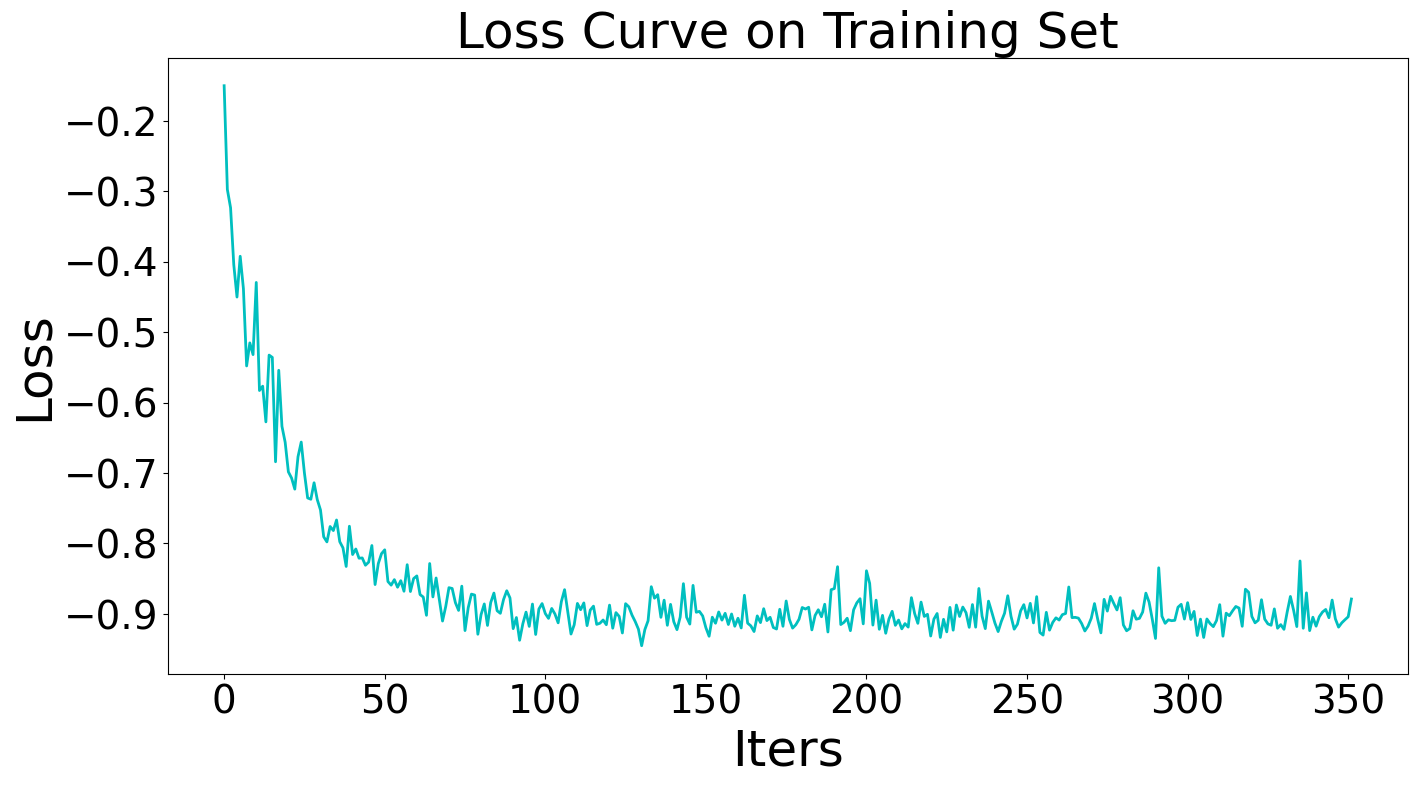

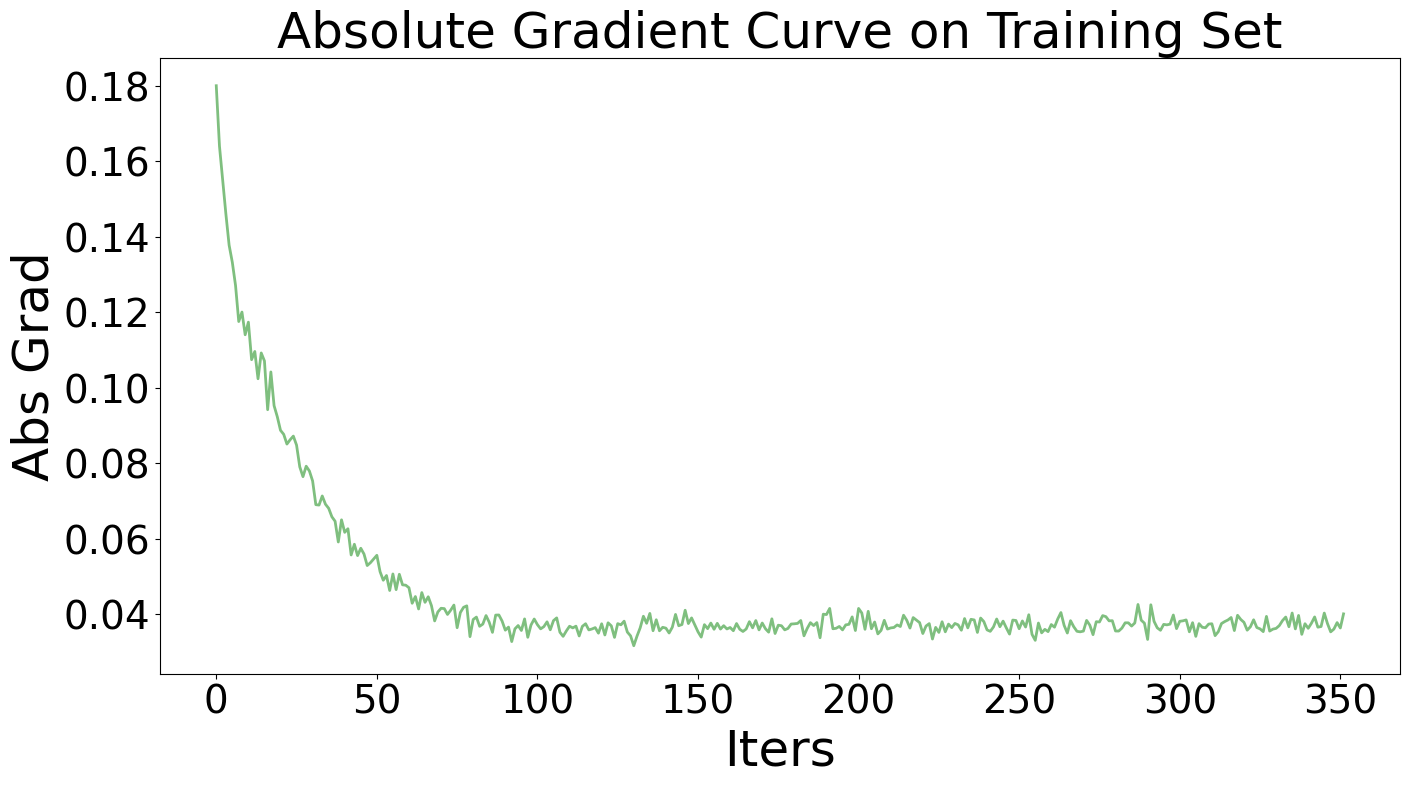

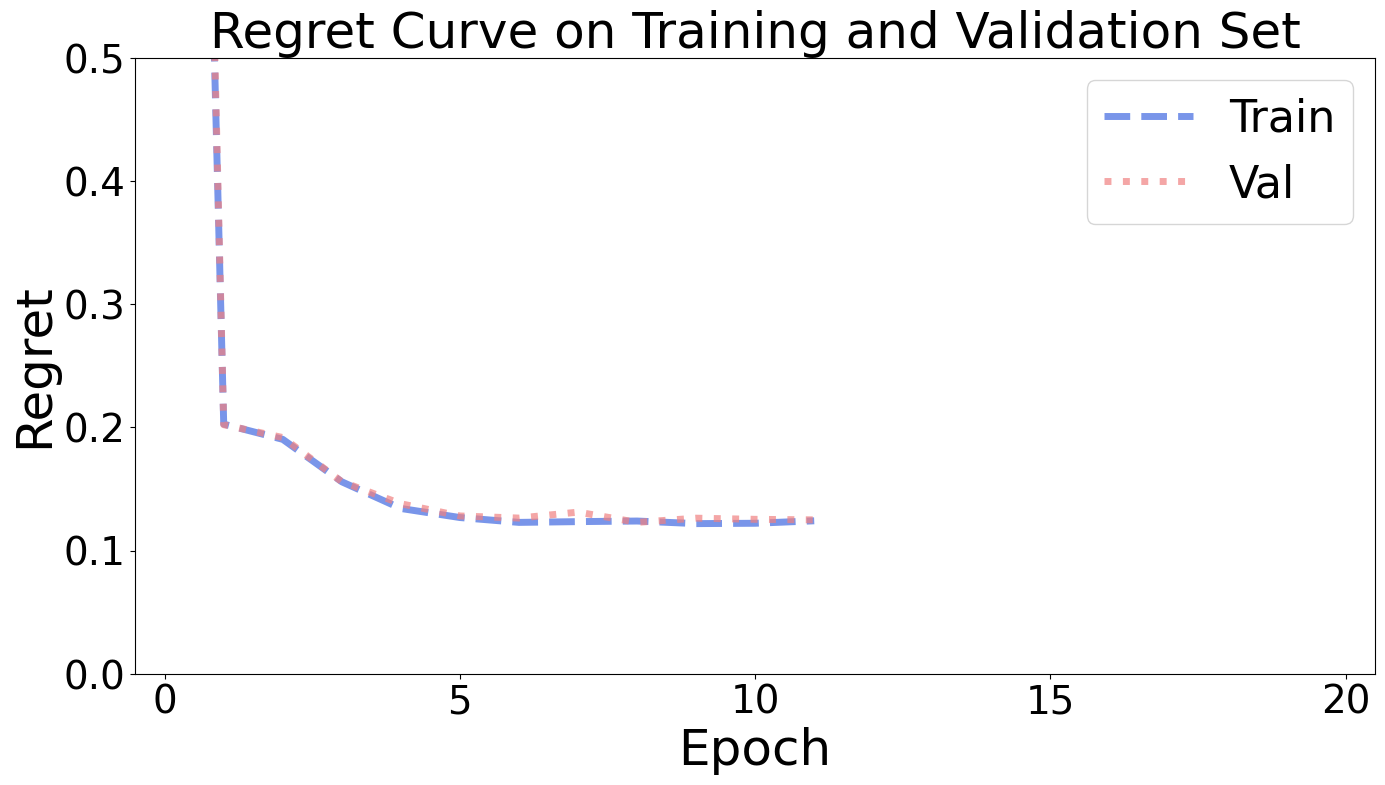

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4)

Num of cores: 1


In [34]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.1426%, Val Regret: 218.8037%


Epoch    0, Loss:  -0.7888:   5%|██▊                                                    | 1/20 [00:19<03:20, 10.55s/it]

Epoch   1, Train Regret:  20.1232%, Val Regret:  19.6724%


Epoch    1, Loss:  -0.9066:  10%|█████▌                                                 | 2/20 [00:30<03:10, 10.56s/it]

Epoch   2, Train Regret:  18.9767%, Val Regret:  19.2476%


Epoch    2, Loss:  -0.8499:  15%|████████▎                                              | 3/20 [00:40<02:59, 10.56s/it]

Epoch   3, Train Regret:  15.8356%, Val Regret:  16.0073%


Epoch    3, Loss:  -0.8249:  20%|███████████                                            | 4/20 [00:51<02:48, 10.52s/it]

Epoch   4, Train Regret:  13.6203%, Val Regret:  13.6546%


Epoch    4, Loss:  -0.9285:  25%|█████████████▊                                         | 5/20 [01:01<02:36, 10.45s/it]

Epoch   5, Train Regret:  12.6130%, Val Regret:  13.3478%


Epoch    5, Loss:  -0.8865:  30%|████████████████▌                                      | 6/20 [01:12<02:26, 10.49s/it]

Epoch   6, Train Regret:  12.2696%, Val Regret:  12.1371%


Epoch    6, Loss:  -0.9027:  35%|███████████████████▎                                   | 7/20 [01:24<02:18, 10.63s/it]

Epoch   7, Train Regret:  12.2170%, Val Regret:  12.3444%


Epoch    7, Loss:  -0.9392:  40%|██████████████████████                                 | 8/20 [01:35<02:12, 11.00s/it]

Epoch   8, Train Regret:  12.5274%, Val Regret:  12.7387%


Epoch    8, Loss:  -0.9074:  45%|████████████████████████▊                              | 9/20 [01:46<02:02, 11.11s/it]

Epoch   9, Train Regret:  12.1214%, Val Regret:  11.8941%


Epoch    9, Loss:  -0.9168:  50%|███████████████████████████                           | 10/20 [01:57<01:50, 11.04s/it]

Epoch  10, Train Regret:  12.2461%, Val Regret:  12.1780%


Epoch   10, Loss:  -0.8726:  55%|█████████████████████████████▋                        | 11/20 [02:08<01:38, 10.94s/it]

Epoch  11, Train Regret:  12.3261%, Val Regret:  12.4169%


Epoch   11, Loss:  -0.8895:  60%|████████████████████████████████▍                     | 12/20 [02:19<01:32, 11.60s/it]


Epoch  12, Train Regret:  12.1734%, Val Regret:  12.6911%

Early Stop!
Training Elapsed Time: 2.79 Sec

Evaluation:
Test Regret: 12.4398%
Test Elapsed Time: 8.79 Sec


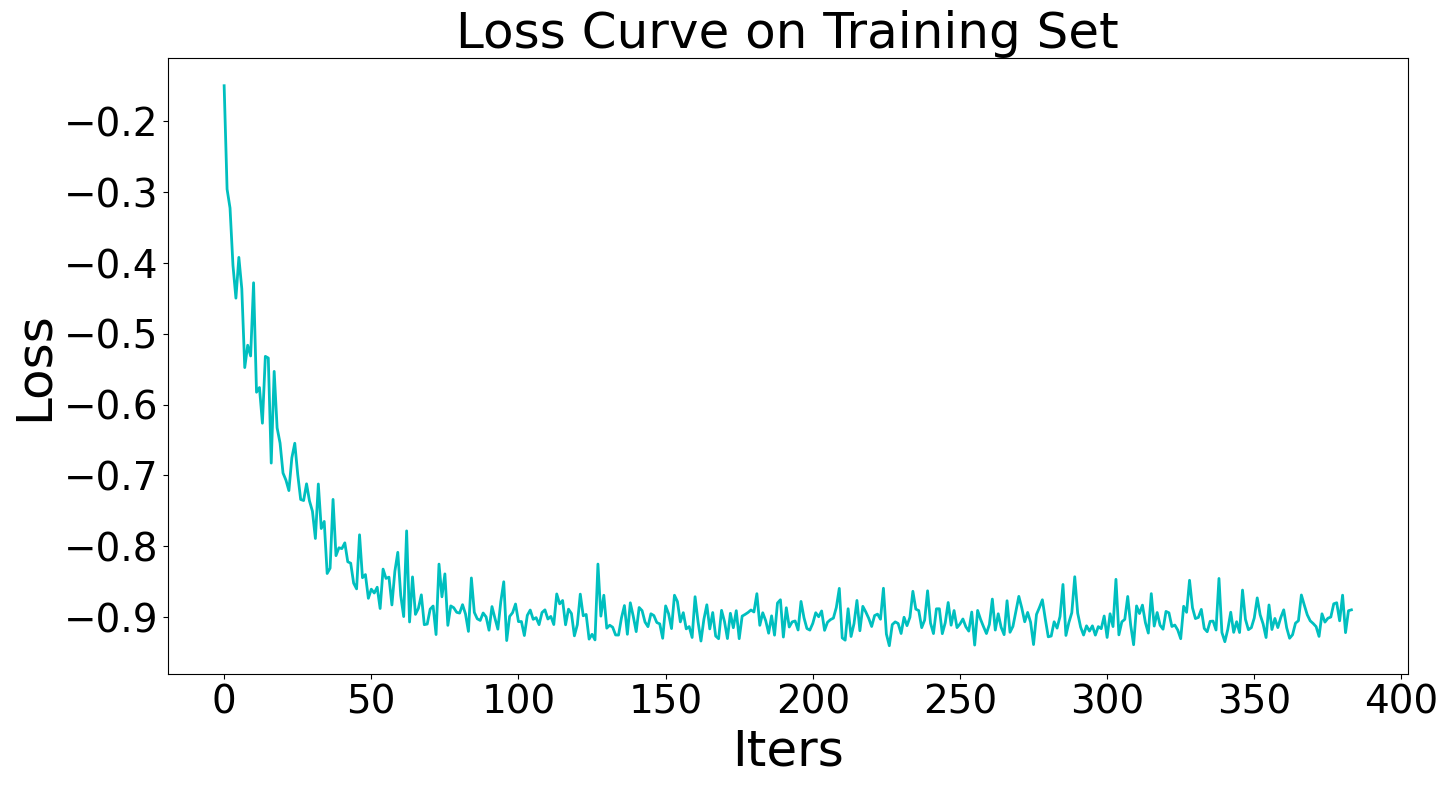

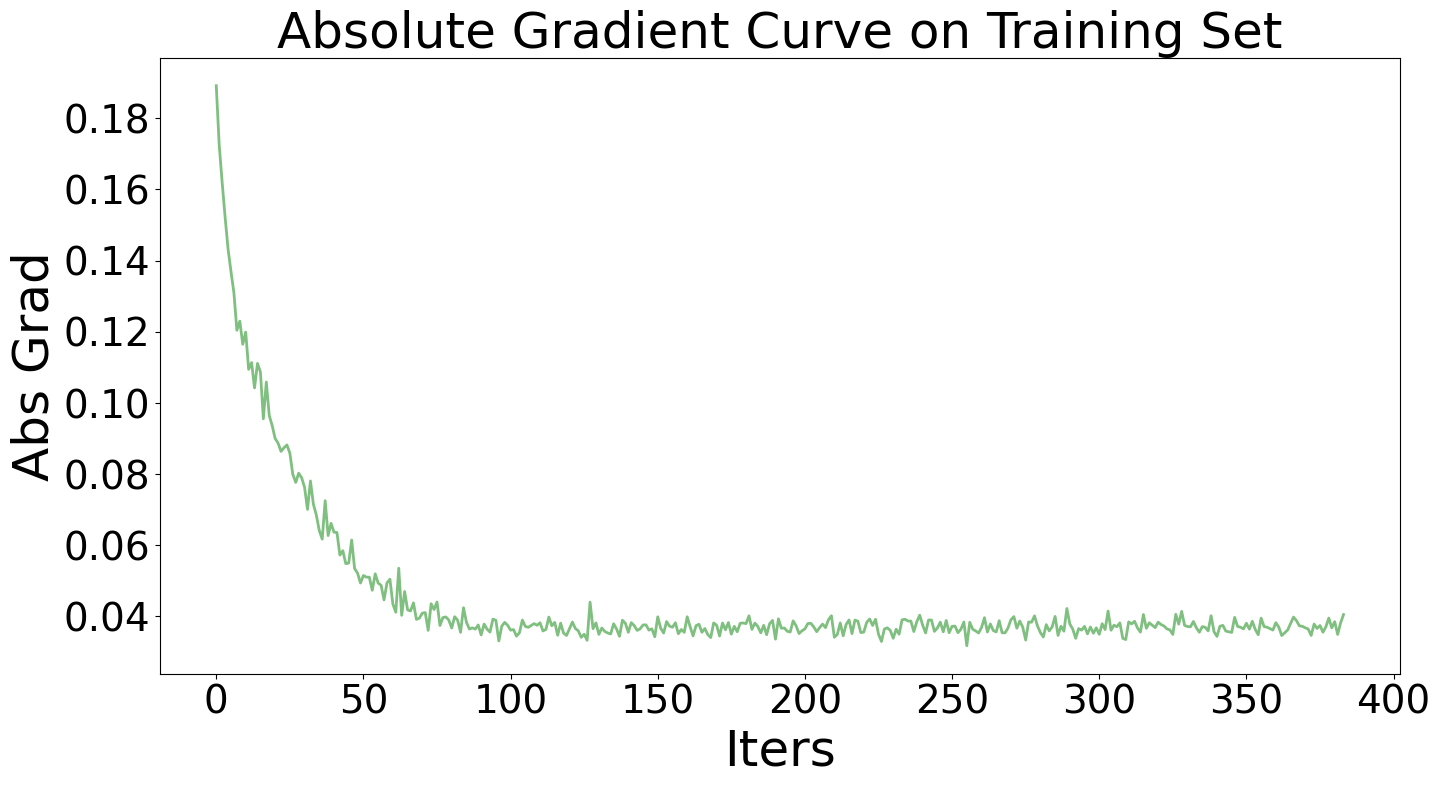

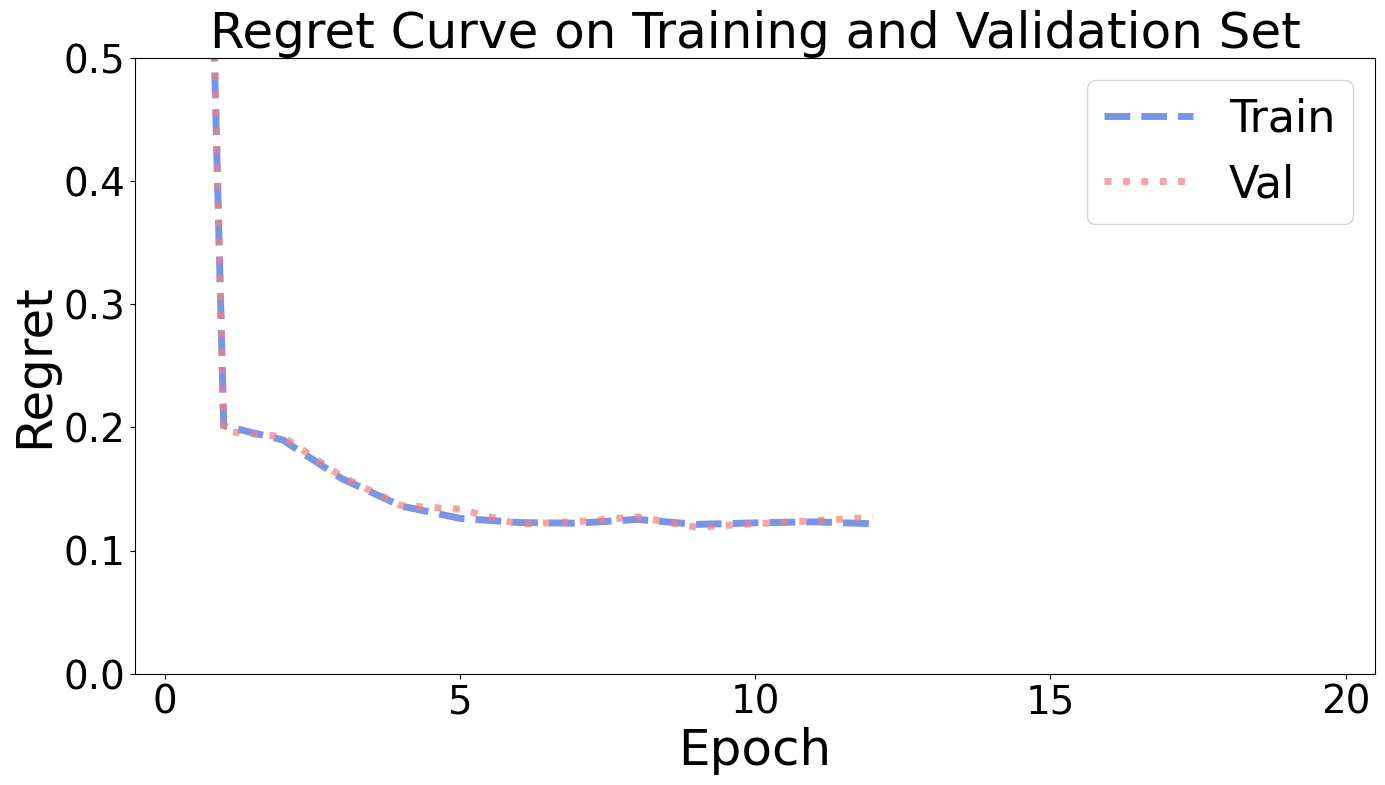

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

###  Average Method with Cone Check

In [36]:
# init model
reg = LinearRegression()

In [37]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel, inner_ratio=0.4, check_cone=True, processes=8)

Num of cores: 8


In [38]:
lr = 1e-1
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/20 [00:09<?, ?it/s]

Epoch   0, Train Regret: 193.4241%, Val Regret: 198.0752%


Epoch    0, Loss:  -0.7906:   5%|██▊                                                    | 1/20 [00:29<06:23, 20.18s/it]

Epoch   1, Train Regret:  19.7569%, Val Regret:  19.9946%


Epoch    1, Loss:  -0.9073:  10%|█████▌                                                 | 2/20 [00:51<06:12, 20.71s/it]

Epoch   2, Train Regret:  18.7656%, Val Regret:  19.2948%


Epoch    2, Loss:  -0.8503:  15%|████████▎                                              | 3/20 [01:11<05:56, 20.96s/it]

Epoch   3, Train Regret:  15.5948%, Val Regret:  15.9092%


Epoch    3, Loss:  -0.8249:  20%|███████████                                            | 4/20 [01:29<05:18, 19.90s/it]

Epoch   4, Train Regret:  13.5571%, Val Regret:  13.7944%


Epoch    4, Loss:  -0.9285:  25%|█████████████▊                                         | 5/20 [01:50<04:51, 19.45s/it]

Epoch   5, Train Regret:  12.5729%, Val Regret:  13.1584%


Epoch    5, Loss:  -0.8866:  30%|████████████████▌                                      | 6/20 [02:10<04:41, 20.14s/it]

Epoch   6, Train Regret:  12.2773%, Val Regret:  12.0419%


Epoch    6, Loss:  -0.9027:  35%|███████████████████▎                                   | 7/20 [02:28<04:14, 19.60s/it]

Epoch   7, Train Regret:  12.1770%, Val Regret:  12.3516%


Epoch    7, Loss:  -0.9392:  40%|██████████████████████                                 | 8/20 [02:47<03:50, 19.23s/it]

Epoch   8, Train Regret:  12.5270%, Val Regret:  12.6615%


Epoch    8, Loss:  -0.9074:  45%|████████████████████████▊                              | 9/20 [03:09<03:38, 19.91s/it]

Epoch   9, Train Regret:  12.1276%, Val Regret:  11.8989%


Epoch    9, Loss:  -0.9168:  50%|███████████████████████████                           | 10/20 [03:28<03:17, 19.76s/it]

Epoch  10, Train Regret:  12.2258%, Val Regret:  12.2114%


Epoch   10, Loss:  -0.8726:  55%|█████████████████████████████▋                        | 11/20 [03:47<02:56, 19.61s/it]

Epoch  11, Train Regret:  12.3312%, Val Regret:  12.4969%


Epoch   11, Loss:  -0.8894:  60%|████████████████████████████████▍                     | 12/20 [04:06<02:44, 20.56s/it]


Epoch  12, Train Regret:  12.1772%, Val Regret:  12.8151%

Early Stop!
Training Elapsed Time: 107.47 Sec

Evaluation:
Test Regret: 12.4255%
Test Elapsed Time: 8.61 Sec


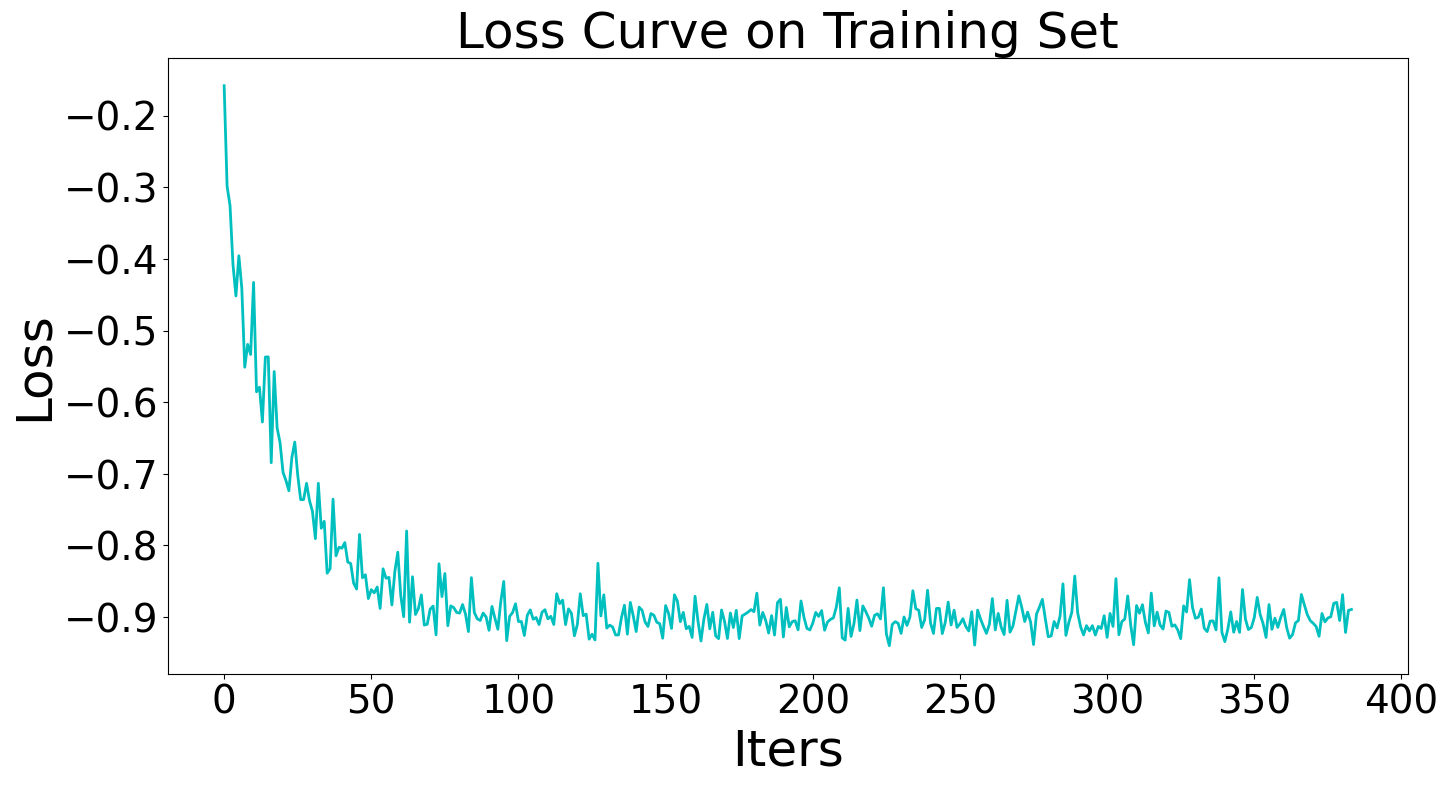

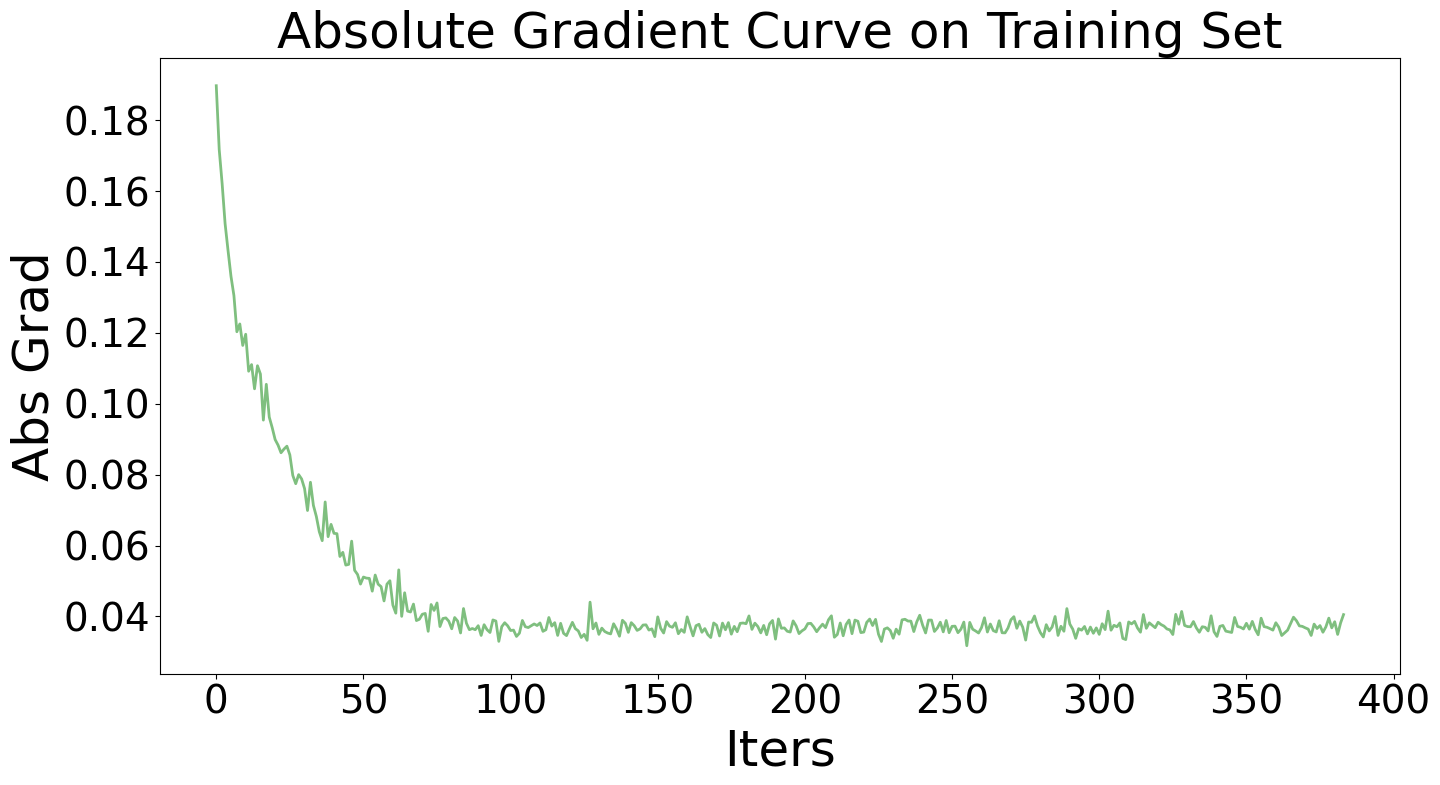

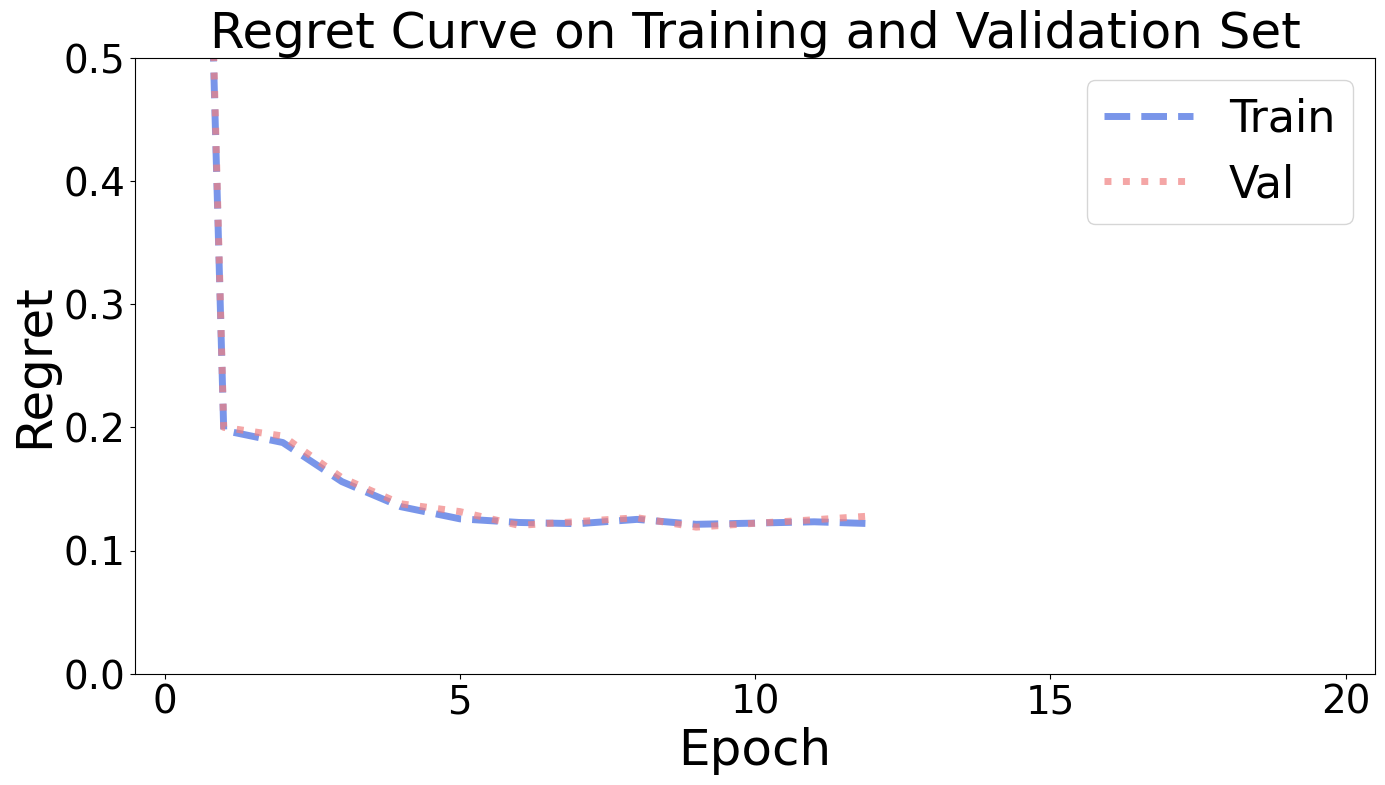

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)